In [7]:
# import libraries
import math
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import pandas as pd
import time
import os
import glob

from moviepy.video.io.bindings import mplfig_to_npimage
import moviepy.editor as mpy
import numpy as np
import glob

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

In [8]:
def bulirsch_stoer_3d_optimized(position, velocity, timestep, Fx, Fy, Fz, args_x, args_y, args_z, N, h, q, p):
    # step 1: modified midpoint method with step size h
    x_values1, y_values1, z_values1, Vx_values1, Vy_values1, Vz_values1 = modified_midpoint_method_optimized(position, velocity, Fx, Fy, Fz, args_x, args_y, args_z, N, h)
    
    # step 2: modified midpoint method with step size h/q
    N_2 = int((timestep * q)/h)
    h_2 = h/q
    
    x_values2, y_values2, z_values2, Vx_values2, Vy_values2, Vz_values2 = modified_midpoint_method_optimized(position, velocity, Fx, Fy, Fz, args_x, args_y, args_z, N_2, h_2)
    
    # step 3: Richardson Extrapolation
    x_final = Richardson_extrapolation(x_values1, x_values2, q, p)
    y_final = Richardson_extrapolation(y_values1, y_values2, q, p)
    z_final = Richardson_extrapolation(z_values1, z_values2, q, p)
    
    Vx_final = Richardson_extrapolation(Vx_values1, Vx_values2, q, p)
    Vy_final = Richardson_extrapolation(Vy_values1, Vy_values2, q, p)
    Vz_final = Richardson_extrapolation(Vz_values1, Vz_values2, q, p)
    
    return (x_final, y_final, z_final), (Vx_final, Vy_final, Vz_final)


def Richardson_extrapolation(f_h, f_hq, q, p):
    return f_h + (f_h - f_hq)/((q**(-p)) -1)


def modified_midpoint_method_optimized(position, velocity, Fx, Fy, Fz, args_x, args_y, args_z, N, h):
    x_values = [None] * (N + 1)
    y_values = [None] * (N + 1)
    z_values = [None] * (N + 1)
    
    Vx_values = [None] * (N + 1)
    Vy_values = [None] * (N + 1)
    Vz_values = [None] * (N + 1)
    
    Fx_values = [None] * (N + 1)
    Fy_values = [None] * (N + 1)
    Fz_values = [None] * (N + 1)
    
    # prep
    x_values[0] = position[0]
    y_values[0] = position[1]
    z_values[0] = position[2]
    
    Vx_values[0] = velocity[0]
    Vy_values[0] = velocity[1]
    Vz_values[0] = velocity[2]
    
    Fx_values[0] = Fx(args_x, Vx_values[0], Vy_values[0], Vz_values[0], x_values[0], y_values[0], z_values[0])
    Fy_values[0] = Fy(args_y, Vx_values[0], Vy_values[0], Vz_values[0], x_values[0], y_values[0], z_values[0])
    Fz_values[0] = Fz(args_z, Vx_values[0], Vy_values[0], Vz_values[0], x_values[0], y_values[0], z_values[0])
    
    # step 1
    # print("step:", 1)
    x_values[1] = x_values[0] + Vx_values[0] * h
    y_values[1] = y_values[0] + Vy_values[0] * h
    z_values[1] = z_values[0] + Vz_values[0] * h

    Vx_values[1] = Vx_values[0] + Fx_values[0] * h
    Vy_values[1] = Vy_values[0] + Fy_values[0] * h
    Vz_values[1] = Vz_values[0] + Fz_values[0] * h

    Fx_values[1] = Fx(args_x, Vx_values[1], Vy_values[1], Vz_values[1], x_values[1], y_values[1], z_values[1])
    Fy_values[1] = Fy(args_y, Vx_values[1], Vy_values[1], Vz_values[1], x_values[1], y_values[1], z_values[1])
    Fz_values[1] = Fz(args_z, Vx_values[1], Vy_values[1], Vz_values[1], x_values[1], y_values[1], z_values[1])

    # steps 2 +
    for n in range(2, N+1):
        # print("step:", n)
        x_values[n] = x_values[n-2] + Vx_values[n-1] * 2 * h
        y_values[n] = y_values[n-2] + Vy_values[n-1] * 2 * h
        z_values[n] = z_values[n-2] + Vz_values[n-1] * 2 * h

        Vx_values[n] = Vx_values[n-2] + Fx_values[n-1] * 2 * h
        Vy_values[n] = Vy_values[n-2] + Fy_values[n-1] * 2 * h
        Vz_values[n] = Vz_values[n-2] + Fz_values[n-1] * 2 * h

        Fx_values[n] = Fx(args_x, Vx_values[n], Vy_values[n], Vz_values[n], x_values[n], y_values[n], z_values[n])
        Fy_values[n] = Fy(args_y, Vx_values[n], Vy_values[n], Vz_values[n], x_values[n], y_values[n], z_values[n])
        Fz_values[n] = Fz(args_z, Vx_values[n], Vy_values[n], Vz_values[n], x_values[n], y_values[n], z_values[n])
    
    # final step
    x_values = 1/2 * (x_values[N] + x_values[N-1] + (h * Vx_values[N]))
    y_values = 1/2 * (y_values[N] + y_values[N-1] + (h * Vy_values[N]))
    z_values = 1/2 * (z_values[N] + z_values[N-1] + (h * Vz_values[N]))

    Vx_values = 1/2 * (Vx_values[N] + Vx_values[N-1] + (h * Fx_values[N]))
    Vy_values = 1/2 * (Vy_values[N] + Vy_values[N-1] + (h * Fy_values[N]))
    Vz_values = 1/2 * (Vz_values[N] + Vz_values[N-1] + (h * Fz_values[N]))
    
    return x_values, y_values, z_values, Vx_values, Vy_values, Vz_values


def runga_kutta_3d_optimized(position, velocity, timestep, Fx, Fy, Fz, args_x, args_y, args_z):
    x_values = [None] * 4
    y_values = [None] * 4
    z_values = [None] * 4
    
    Vx_values = [None] * 4
    Vy_values = [None] * 4
    Vz_values = [None] * 4
    
    Fx_values = [None] * 4
    Fy_values = [None] * 4
    Fz_values = [None] * 4
    
    # step 1
    x_values[0] = position[0]
    y_values[0] = position[1]
    z_values[0] = position[2]
    
    Vx_values[0] = velocity[0]
    Vy_values[0] = velocity[1]
    Vz_values[0] = velocity[2]
    
    Fx_values[0] = Fx(args_x, Vx_values[0], Vy_values[0], Vz_values[0], x_values[0], y_values[0], z_values[0])
    Fy_values[0] = Fy(args_y, Vx_values[0], Vy_values[0], Vz_values[0], x_values[0], y_values[0], z_values[0])
    Fz_values[0] = Fz(args_z, Vx_values[0], Vy_values[0], Vz_values[0], x_values[0], y_values[0], z_values[0])
    
    # step 2
    x_values[1] = x_values[0] + Vx_values[0] * timestep/2
    y_values[1] = y_values[0] + Vy_values[0] * timestep/2
    z_values[1] = z_values[0] + Vz_values[0] * timestep/2
    
    Vx_values[1] = Vx_values[0] + Fx_values[0] * timestep/2
    Vy_values[1] = Vy_values[0] + Fy_values[0] * timestep/2
    Vz_values[1] = Vz_values[0] + Fz_values[0] * timestep/2
    
    Fx_values[1] = Fx(args_x, Vx_values[1], Vy_values[1], Vz_values[1], x_values[1], y_values[1], z_values[1])
    Fy_values[1] = Fy(args_y, Vx_values[1], Vy_values[1], Vz_values[1], x_values[1], y_values[1], z_values[1])
    Fz_values[1] = Fz(args_z, Vx_values[1], Vy_values[1], Vz_values[1], x_values[1], y_values[1], z_values[1])
    
    # step 3
    x_values[2] = x_values[0] + Vx_values[1] * timestep/2
    y_values[2] = y_values[0] + Vy_values[1] * timestep/2
    z_values[2] = z_values[0] + Vz_values[1] * timestep/2
    
    Vx_values[2] = Vx_values[0] + Fx_values[1] * timestep/2
    Vy_values[2] = Vy_values[0] + Fy_values[1] * timestep/2
    Vz_values[2] = Vz_values[0] + Fz_values[1] * timestep/2
    
    Fx_values[2] = Fx(args_x, Vx_values[2], Vy_values[2], Vz_values[2], x_values[2], y_values[2], z_values[2])
    Fy_values[2] = Fy(args_y, Vx_values[2], Vy_values[2], Vz_values[2], x_values[2], y_values[2], z_values[2])
    Fz_values[2] = Fz(args_z, Vx_values[2], Vy_values[2], Vz_values[2], x_values[2], y_values[2], z_values[2])
    
    # step 4
    x_values[3] = x_values[0] + Vx_values[2] * timestep
    y_values[3] = y_values[0] + Vy_values[2] * timestep
    z_values[3] = z_values[0] + Vz_values[2] * timestep
    
    Vx_values[3] = Vx_values[0] + Fx_values[2] * timestep
    Vy_values[3] = Vy_values[0] + Fy_values[2] * timestep
    Vz_values[3] = Vz_values[0] + Fz_values[2] * timestep
    
    Fx_values[3] = Fx(args_x, Vx_values[3], Vy_values[3], Vz_values[3], x_values[3], y_values[3], z_values[3])
    Fy_values[3] = Fy(args_y, Vx_values[3], Vy_values[3], Vz_values[3], x_values[3], y_values[3], z_values[3])
    Fz_values[3] = Fz(args_z, Vx_values[3], Vy_values[3], Vz_values[3], x_values[3], y_values[3], z_values[3])
    
    # step 5
    x_final = x_values[0] + ((Vx_values[0] + 2*Vx_values[1] + 2*Vx_values[2] + Vx_values[3])*timestep)/6
    y_final = y_values[0] + ((Vy_values[0] + 2*Vy_values[1] + 2*Vy_values[2] + Vy_values[3])*timestep)/6
    z_final = z_values[0] + ((Vz_values[0] + 2*Vz_values[1] + 2*Vz_values[2] + Vz_values[3])*timestep)/6
    
    Vx_final = Vx_values[0] + ((Fx_values[0] +2*Fx_values[1] +2*Fx_values[2] + Fx_values[3])*timestep)/6
    Vy_final = Vy_values[0] + ((Fy_values[0] +2*Fy_values[1] +2*Fy_values[2] + Fy_values[3])*timestep)/6
    Vz_final = Vz_values[0] + ((Fz_values[0] +2*Fz_values[1] +2*Fz_values[2] + Fz_values[3])*timestep)/6
    
    return (x_final, y_final, z_final), (Vx_final, Vy_final, Vz_final)

In [9]:
def gravitational_force(args, Vx, Vy, Vz, x, y, z):
    n = args[0] # position of body in array of all bodies
    m = args[1] # mass array
    component = args[2] # "x", "y", or "z"
    x_all = args[3] # last x position of all bodies (array)
    y_all = args[4] # last x position of all bodies (array)
    z_all = args[5] # last x position of all bodies (array)
    G_or_const = args[6]
    
    F = 0

    for body in range(len(x_all)):
        if body != n:
            # claculate distance between 2 bodies
            r =  math.sqrt((x_all[body] - x)**2 + (y_all[body] - y)**2 + (z_all[body] - z)**2)
            # print("r:", r)
            if component == "x":
                F -= G_or_const * m[body] * ((x - x_all[body])/r**3) # - because x - x_all and ot x_all - x
            elif component == "y":
                F -= G_or_const * m[body] * ((y - y_all[body])/r**3)
            elif component == "z":
                F -= G_or_const * m[body] * ((z - z_all[body])/r**3)      
    return F

def run_simulation(input_file, n_timesteps, timestep, func_integration, args):
    df = pd.read_csv(input_file)
    bodies = list(df['body'])
    df = df.set_index('body')
    n_bodies = len(df)
    # print(n_bodies, "bodies:", bodies)
    display(df)
    
    # set array of masses and normalize
    m = list(df["mass"])
    m = [i/mass_sun for i in m]
    # print("Masses:", m)

    # initialization positions and velocities
    x = [[None] * (n_timesteps + 1) for _ in range(n_bodies)]
    y = [[None] * (n_timesteps + 1) for _ in range(n_bodies)]
    z = [[None] * (n_timesteps + 1) for _ in range(n_bodies)]
    Vx = [[None] * (n_timesteps + 1) for _ in range(n_bodies)]
    Vy = [[None] * (n_timesteps + 1) for _ in range(n_bodies)]
    Vz = [[None] * (n_timesteps + 1) for _ in range(n_bodies)]
    
    for n in range(n_bodies):
        row = df.loc[bodies[n]]
        x[n][0] = row.x/AU
        y[n][0] = row.y/AU
        z[n][0] = row.z/AU

        Vx[n][0] = row.Vx*(year/AU)
        Vy[n][0] = row.Vy*(year/AU)
        Vz[n][0] = row.Vz*(year/AU)
    
    if func_integration == "Bulirsch-Stoer" or func_integration == "Bulirsch-Stoer_optimized":
        N = args[0]
        h = args[1]
        q = args[2]
        p = args[3]
    
    start_time = time.time()
    # run simulation
    for t in range(n_timesteps):
        # set array with latest position for all bodies
        x_last_all = [None] * n_bodies
        y_last_all = [None] * n_bodies
        z_last_all = [None] * n_bodies
        
        for n in range(n_bodies):
            x_last_all[n] = x[n][t]
            y_last_all[n] = y[n][t]
            z_last_all[n] = z[n][t]
            
        for n in range(n_bodies):
            # for a specific body: p_components are its position, c_components are its velocity components
            p_components = (x_last_all[n], y_last_all[n], z_last_all[n])
            v_components = (Vx[n][t], Vy[n][t], Vz[n][t])

            args_x = (n, m, "x", x_last_all, y_last_all, z_last_all, norm_const)
            args_y = (n, m, "y", x_last_all, y_last_all, z_last_all, norm_const)
            args_z = (n, m, "z", x_last_all, y_last_all, z_last_all, norm_const)
            
            if func_integration == "Bulirsch-Stoer":
                p_components, v_components = bulirsch_stoer_3d(p_components, v_components, timestep, gravitational_force, gravitational_force, gravitational_force, args_x, args_y, args_z, N, h, q, p)  
            elif func_integration == "Bulirsch-Stoer_optimized":
                p_components, v_components = bulirsch_stoer_3d_optimized(p_components, v_components, timestep, gravitational_force, gravitational_force, gravitational_force, args_x, args_y, args_z, N, h, q, p)  
            elif func_integration == "Runga-Kutta":
                p_components, v_components = runga_kutta_3d(p_components, v_components, timestep, gravitational_force, gravitational_force, gravitational_force, args_x, args_y, args_z)
            elif func_integration == "Runga-Kutta_optimized":
                p_components, v_components = runga_kutta_3d_optimized(p_components, v_components, timestep, gravitational_force, gravitational_force, gravitational_force, args_x, args_y, args_z)
        
            # add new value in arrays
            x[n][t+1] = p_components[0]
            y[n][t+1] = p_components[1]
            z[n][t+1] = p_components[2]

            Vx[n][t+1] = v_components[0]
            Vy[n][t+1] = v_components[1]
            Vz[n][t+1] = v_components[2]
            
    exec_time = time.time() - start_time
    return n_bodies, bodies, x, y, z, exec_time

# instead of keeping all positions in memory in array, this function stores positions in files
def run_simulation_save(input_file, n_timesteps, timestep, func_integration, args, folder, step_save):
    df = pd.read_csv(input_file)
    bodies = list(df['body'])
    df = df.set_index('body')
    n_bodies = len(df)
    # print(n_bodies, "bodies:", bodies)
    display(df)
    
    # set array of masses and normalize
    m = list(df["mass"])
    m = [i/mass_sun for i in m]
    # print("Masses:", m)

    # initialization positions and velocities in temporary arrays (changed at each step)
    x = [None] * n_bodies
    y = [None] * n_bodies
    z = [None] * n_bodies
    Vx = [None] * n_bodies
    Vy = [None] * n_bodies
    Vz = [None] * n_bodies
    
    # initiaization folder
    create_empty_folder(folder)
    
    for n in range(n_bodies):
        row = df.loc[bodies[n]]
        x[n] = row.x/AU
        y[n] = row.y/AU
        z[n] = row.z/AU

        Vx[n] = row.Vx*(year/AU)
        Vy[n] = row.Vy*(year/AU)
        Vz[n] = row.Vz*(year/AU)
    # save
    save_timestep(bodies, x, y, z, Vx, Vy, Vz, folder, 0)
    
    if func_integration == "Bulirsch-Stoer" or func_integration == "Bulirsch-Stoer_optimized":
        N = args[0]
        h = args[1]
        q = args[2]
        p = args[3]
    
    start_time = time.time()
    # run simulation
    for t in range(1, n_timesteps + 1):
    
        for n in range(n_bodies):
            # for a specific body: p_components are its position, c_components are its velocity components
            p_components = (x[n], y[n], z[n])
            v_components = (Vx[n], Vy[n], Vz[n])

            args_x = (n, m, "x", x, y, z, norm_const)
            args_y = (n, m, "y", x, y, z, norm_const)
            args_z = (n, m, "z", x, y, z, norm_const)
            
            if func_integration == "Bulirsch-Stoer":
                p_components, v_components = bulirsch_stoer_3d(p_components, v_components, timestep, gravitational_force, gravitational_force, gravitational_force, args_x, args_y, args_z, N, h, q, p)  
            elif func_integration == "Bulirsch-Stoer_optimized":
                p_components, v_components = bulirsch_stoer_3d_optimized(p_components, v_components, timestep, gravitational_force, gravitational_force, gravitational_force, args_x, args_y, args_z, N, h, q, p)  
            elif func_integration == "Runga-Kutta":
                p_components, v_components = runga_kutta_3d(p_components, v_components, timestep, gravitational_force, gravitational_force, gravitational_force, args_x, args_y, args_z)
            elif func_integration == "Runga-Kutta_optimized":
                p_components, v_components = runga_kutta_3d_optimized(p_components, v_components, timestep, gravitational_force, gravitational_force, gravitational_force, args_x, args_y, args_z)
        
            # save new values in arrays
            x[n] = p_components[0]
            y[n] = p_components[1]
            z[n] = p_components[2]

            Vx[n] = v_components[0]
            Vy[n] = v_components[1]
            Vz[n] = v_components[2]
            
        # save values in files
        if t % step_save == 0:
            save_timestep(bodies, x, y, z, Vx, Vy, Vz, folder, t)   
                 
    exec_time = time.time() - start_time
    return n_bodies, bodies, exec_time

def create_empty_folder(folder):
    if os.path.exists(folder):
        files = glob.glob(folder + '/*')
        for f in files:
            os.remove(f)
    else:
        os.mkdir(folder)

def save_timestep(bodies, x, y, z, Vx, Vy, Vz, folder, timestep):
    # create dataframe
    df = pd.DataFrame()
    df["body"] = bodies
    df["x"] = x
    df["y"] = y
    df["z"] = z
    df["Vx"] = Vx
    df["Vy"] = Vy
    df["Vz"] = Vz
    
    df.to_csv(folder + "/t_%s.csv"%(str(timestep)), index = False)

def get_positions_from_files(folder, timesteps, n_bodies):
    # position arrays
    n_timesteps = len(timesteps)
    x = [[None] * (n_timesteps) for _ in range(n_bodies)]
    y = [[None] * (n_timesteps) for _ in range(n_bodies)]
    z = [[None] * (n_timesteps) for _ in range(n_bodies)]
    
    # populate position arrays
    index = 0
    for timestep in timesteps:
        df = pd.read_csv(folder + "/t_%s.csv"%(str(timestep)))
        x_tmp = list(df["x"])
        y_tmp = list(df["y"])
        z_tmp = list(df["z"])
        
        for n in range(n_bodies):
            x[n][index] = x_tmp[n]
            y[n][index] = y_tmp[n]
            z[n][index] = z_tmp[n]  
        index += 1
        
    return x, y, z

In [10]:
# non-dimentionalize code
# universal gravitation constant
G = 6.67259e-20  # (km**3/kg/s**2)
mass_sun = 1.989e30 # kg
AU = 1.496e8 #km
year = 3.156e7 #s
norm_const = (G * mass_sun * (year**2))/(AU**3)
# print(norm_const)

In [11]:
# initial conditions: store in arrays
# NASA JBL 01/01/2023 for eath and sun (vector table)
# observer: solar system barycenter 
input_file = "bodies2.csv"
output_trajectories = "blender/trajectories_step7.csv"

n_days_timestep = 1 # timestep in number of days
n_days_total = 365 * 165 # total number of days I want to simulate
n_timesteps = int(n_days_total/n_days_timestep) # number of timesteps for simulation
print("Number of timesteps:", n_timesteps)

timestep = (86400/year) * n_days_timestep # (86400/year) = 1 day in non dimensional
print("Timestep:", timestep)

# variables for Bulirsch-Stoer method
N = 4
h = timestep/N
q = 2
p = 1

func_integration = "Bulirsch-Stoer_optimized" #"Runga-Kutta" "Bulisrsch-Stoer"  "Runga-Kutta_optimized"
args_bulirsch_stoer = [N, h, q, p]

Number of timesteps: 60225
Timestep: 0.0027376425855513307


In [12]:
n_bodies, bodies, x, y, z, exec_time = run_simulation(input_file, n_timesteps, timestep, func_integration, args_bulirsch_stoer)
print(exec_time)
print(bodies)

,x,y,z,Vx,Vy,Vz,mass
body,,,,,,,
sun,-1.355e+06,1.421e+04,3.144e+04,0.002,-0.016,8.962e-05,1.989e+30
earth,-2.682e+07,1.449e+08,2.413e+04,-29.815,-5.296,-5.494e-04,5.972e+24
jupiter,7.224e+08,1.564e+08,-1.681e+07,-2.913,13.384,9.666e-03,1.899e+27
saturn,1.217e+09,-8.235e+08,-3.415e+07,4.873,7.982,-3.327e-01,5.683e+26
neptune,4.451e+09,-4.402e+08,-9.351e+07,0.499,5.441,-1.236e-01,1.024e+26
uranus,1.999e+09,2.158e+09,-1.788e+07,-5.046,4.310,8.140e-02,8.681e+25
venus,8.259e+07,-6.916e+07,-5.762e+06,22.050,26.878,-9.029e-01,4.867e+24
mars,7.753e+06,2.338e+08,4.708e+06,-23.292,2.986,6.344e-01,6.416e+23
mercury,1.764e+07,4.206e+07,1.725e+06,-54.131,21.933,6.759e+00,3.285e+23


233.55443930625916
['sun', 'earth', 'jupiter', 'saturn', 'neptune', 'uranus', 'venus', 'mars', 'mercury']


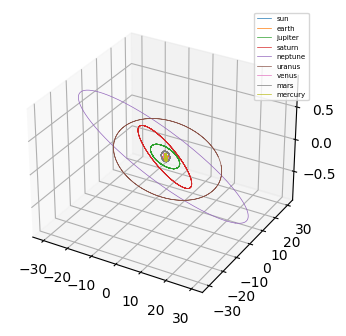

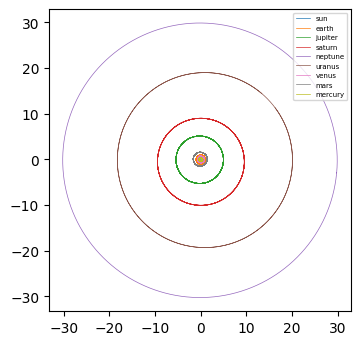

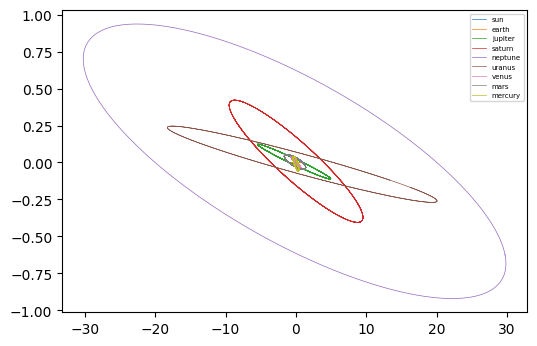

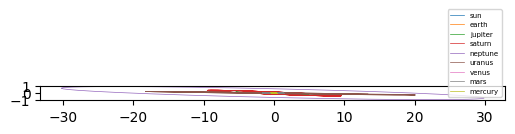

In [13]:
ax = plt.figure(dpi = 100).add_subplot(projection='3d')
for i in range(n_bodies):
    ax.plot(x[i], y[i], z[i], label = bodies[i], linewidth = 0.5)
ax.legend(fontsize="5")
plt.show()

fig = plt.figure(dpi = 100)
ax = plt.subplot()
ax.set_aspect("equal")
for i in range(n_bodies):
    ax.plot(x[i], y[i], label = bodies[i], linewidth = 0.5)
ax.legend(fontsize="5")
plt.show()

fig = plt.figure(dpi = 100)
ax = plt.subplot()
# ax.set_aspect("equal")
for i in range(n_bodies):
    ax.plot(x[i], z[i], label = bodies[i], linewidth = 0.5)
ax.legend(fontsize="5")
plt.show()

fig = plt.figure(dpi = 100)
ax = plt.subplot()
ax.set_aspect("equal")
for i in range(n_bodies):
    ax.plot(x[i], z[i], label = bodies[i], linewidth = 0.5)
ax.legend(fontsize="5")
plt.show()

In [14]:
df_result = pd.DataFrame()
for n in range(len(bodies)):
    df_result["x_%s"%(bodies[n])] =  x[n]
    df_result["y_%s"%(bodies[n])] =  y[n]
    df_result["z_%s"%(bodies[n])] =  z[n]
for body in bodies:
    df_result[body] = df_result["x_%s"%(body)].astype(str) + "_" + df_result["y_%s"%(body)].astype(str) + "_" + df_result["z_%s"%(body)].astype(str)
    df_result = df_result.drop(labels = ["x_%s"%(body), "y_%s"%(body), "z_%s"%(body)], axis = 1)
display(df_result) 

df_result.to_csv(output_trajectories, index = False)   

,sun,earth,jupiter,saturn,neptune,uranus,venus,mars,mercury
0,-0.009055016159966617_9.495630345800982e-05_0....,-0.1793085625550183_0.9685666471737507_0.00016...,4.8291006685631475_1.0453167199420428_-0.11237...,8.138215814399752_-5.504951619894438_-0.228301...,29.75138566404254_-2.9426746516096243_-0.62505...,13.360498481186276_14.426954287758068_-0.11950...,0.5521040013798607_-0.46228718968658006_-0.038...,0.051822082348051066_1.562825907716532_0.03146...,0.11791618807725736_0.28112208900729396_0.0115...
1,-0.009054064563354926_8.595783047452334e-05_0....,-0.19650039658806656_0.9653574900318579_0.0001...,4.82741227307342_1.0530451470677433_-0.1123709...,8.141028764113106_-5.500340785888917_-0.228493...,29.751673897841012_-2.939532010247272_-0.62512...,13.35758382656516_14.429443133287203_-0.119458...,0.5646217451617497_-0.4465888644016675_-0.0390...,0.0383680356449914_1.5644900485929931_0.031834...,0.08606652751966322_0.2923483601768359_0.01536...
2,-0.009053099858418262_7.696190215023372e-05_0....,-0.213633874919855_0.9618478877019825_0.000160...,4.825712085314839_1.0607710053605275_-0.112364...,8.14383917636886_-5.495728236230101_-0.2286858...,29.75196180193829_-2.936389336315368_-0.625194...,13.35466865151445_14.431931416537601_-0.119411...,0.5766997486083203_-0.4305481310641361_-0.0395...,0.02491034234894028_1.5660335091431121_0.03219...,0.05325235808440238_0.3006101481229455_0.01905...
3,-0.009052122095155058_6.796858232679415e-05_0....,-0.2307036616098528_0.9580389164846741_0.00016...,4.824000109359398_1.0684942759455747_-0.112358...,8.146647050100716_-5.491113972231841_-0.228877...,29.75224937633051_-2.933246629848627_-0.625266...,13.351752956135236_14.434419137398724_-0.11936...,0.5883287026707649_-0.4141772548897264_-0.0399...,0.011450046670040152_1.5674564491693252_0.0325...,0.019804795018129602_0.30581701957625196_0.022...
4,-0.009051131326736067_5.897792711756969e-05_0....,-0.2477044411129268_0.9539317504938394_0.00016...,4.822276349312087_1.0762149399550607_-0.112352...,8.149452384242942_-5.4864979952086586_-0.22906...,29.752536621013817_-2.9301038908817674_-0.6253...,13.348836740528611_14.436906295760064_-0.11931...,0.5994996334201281_-0.39748875213860196_-0.040...,-0.002011811808400585_1.5687590364163133_0.032...,-0.013935329043133422_0.3079285639602676_0.025...
...,...,...,...,...,...,...,...,...,...
60221,-0.0033405822939937494_0.0025783155435009607_-...,0.0008086268373958074_0.9865703638473119_-0.00...,4.384273195802465_-2.421374800076024_-0.087400...,-9.346465120852827_-2.2003880634855717_0.41188...,29.75560704648455_-2.8634091190649213_-0.62704...,16.295432115835325_11.291146095317986_-0.16881...,0.5909704343910162_-0.4163388055545671_-0.0401...,1.0261618295293222_-0.926325750344897_-0.04440...,0.2731553492991381_0.2355675523490526_-0.00614...
60222,-0.0033441349651725065_0.0025728793467835517_-...,-0.01667188215961145_0.9864095129620369_-0.000...,4.387820258062908_-2.4144067175038164_-0.08750...,-9.345490812989953_-2.2058334750295323_0.41193...,29.755886693814837_-2.8602652145345875_-0.6271...,16.293163069966404_11.294194359988943_-0.16877...,0.6022696738754219_-0.3997389056059465_-0.0405...,1.0359922062806188_-0.914680583671291_-0.04439...,0.2494130298658189_0.2531167025015556_-0.00253...
60223,-0.003347677203203328_0.002567437900501709_-2....,-0.034148243370766475_0.9859430156682556_-0.00...,4.391357005824903_-2.4074329578083797_-0.08761...,-9.344513387077281_-2.211278149866121_0.411993...,29.756166011279827_-2.8571212782878117_-0.6271...,16.290893404720684_11.297242195211728_-0.16873...,0.613104825965471_-0.382830706498957_-0.040954...,1.045707312974973_-0.9029336787411765_-0.04438...,0.22401324423140498_0.2690206704666978_0.00108...
60224,-0.0033512090070676936_0.0025619912817280606_-...,-0.05161502665543312_0.985170950916898_-0.0004...,4.394883429192766_-2.400453536516303_-0.087726...,-9.343532843734687_-2.2167220862486543_0.41204...,29.75644499887567_-2.8539773103593387_-0.62725...,16.2886231201723

In [4]:
# now aimate blender images

folder = "blender/render1"
output_file = "blender/animation_1.mp4"
fps = 24

file_list = np.array(sorted(glob.glob(folder + '/*.png')))
order = np.array([int(f.split("/")[-1].split(".")[0]) for f in file_list])
sortIx = np.argsort(order)
file_list = list(file_list[sortIx])

clip = mpy.ImageSequenceClip(file_list, fps=fps)
clip.write_videofile(output_file)

Moviepy - Building video animation_1.mp4.
Moviepy - Writing video animation_1.mp4



Moviepy - Done !
Moviepy - video ready animation_1.mp4


In [5]:

folder = "blender/render2"
output_file = "blender/animation_2.mp4"
fps = 24

file_list = np.array(sorted(glob.glob(folder + '/*.png')))
order = np.array([int(f.split("/")[-1].split(".")[0]) for f in file_list])
sortIx = np.argsort(order)
file_list = list(file_list[sortIx])

clip = mpy.ImageSequenceClip(file_list, fps=fps)
clip.write_videofile(output_file)

Moviepy - Building video blender/animation_2.mp4.
Moviepy - Writing video blender/animation_2.mp4



Moviepy - Done !
Moviepy - video ready blender/animation_2.mp4
